In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
import itertools as it
import sys
import progressbar
from scipy.optimize import curve_fit


In [2]:
#folder_st = folder + "*"
#!wc -l $folder_st
#!ls $folder

In [86]:
#  load main data for layers

folder = "data_io/"
analysis_type = "layer"
xlabel = r"click probability layer $p$"

v_N = np.array([20,25,30,35,40, 45, 50, 55, 60])
v_p = np.array([.35,.38,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95])

N_collect = 99

prefix = "dat"
suffix = ".txt"

N_N = v_N.size
N_p = v_p.size

In [1]:
#  load measurement data for test

folder = "data_io_measurement/"
analysis_type = "measurement"
xlabel = r"measurement rate $p/\gamma$"

v_N = np.array([8,12,16,20,24,28,32,36,40])
v_p = np.array([0.,.1,.2,.4,.6,.8,1.,1.2,1.4,1.6,1.8,2.,2.4,2.8,3.2,4.,5.])

N_collect = 99

prefix = "dat"
suffix = ".txt"

N_N = v_N.size
N_p = v_p.size

!ls $folder

NameError: name 'np' is not defined

In [73]:


data_list = []
err_list = []
num_list = []

# the loop with progress bar
bar = progressbar.ProgressBar(maxval=N_N*N_p, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

count = 0
bar.start()   

for i_N in range(N_N):
    N = v_N[i_N]
    dat_N = np.zeros((N_p,N_collect+1,N+1))
    err_N = np.zeros((N_p,N_collect+1,N+1))
    num_N = np.zeros((N_p,N_collect))
    for i_p in range(N_p):
        p = v_p[i_p]
        for i in range(N_collect):
            fn = folder + prefix + "_N_" + str(N) + "_p_" + "{:.6f}".format(p) + "_" + str(i) + suffix
            
            try:
                data = np.loadtxt(fn)
            except:
                data = -np.ones(2,N+1)

            num_N[i_p,i] = data.shape[0]

            dat_N[i_p,i+1,:] = np.mean(data,axis=0)
            err_N[i_p,i+1,:] = np.std(data,axis=0)/np.sqrt(num_N[i_p,i])
            
        count += 1
        bar.update(count)


    data_list.append(dat_N)
    err_list.append(err_N)
    num_list.append(num_N)

bar.finish()
    
#outfile = folder + "save" + "_N_" + str(N_spin) + "_Ns_" + str(N_sample)
#np.save(outfile, full_data)

[========================================================================] 100%


In [6]:
#outfile = folder + "full_data"
#np.save(outfile, data_list, allow_pickle=True)
#, err_list=err_list, num_list=num_list)

In [7]:
#np.load(outfile, full_data + ".npz")

Text(0.5, 1.0, 'N=60')

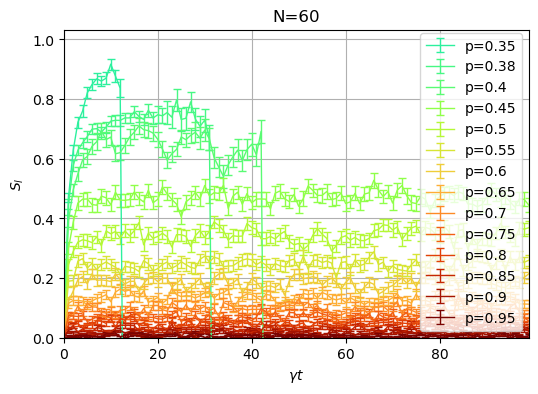

In [76]:
N_plot = 60
i_site = (N_plot)//2

plt.figure(figsize=(6,4))

i_N = np.argmin(np.abs(v_N-N_plot))

x_axis = np.linspace(0,N_collect,N_collect+1)
cmap = matplotlib.cm.turbo

for i_p, p in list(enumerate(v_p)):
    dat = data_list[i_N][i_p,:,i_site]
    err = err_list[i_N][i_p,:,i_site]

    #_ = plt.errorbar(x_axis,0.5*(dat+np.flip(dat)), yerr=err_S[i_L,i_jump,:], linewidth = 1, color = 'black')
    
    _ = plt.errorbar(x_axis,dat , yerr=err, linewidth = 1, capsize=3, color=cmap(p/np.max(v_p)), label="p="+str(p))
    #_ = plt.plot(x_axis,dat, linewidth = 1, color='blue')

plt.xlim(0,N_collect)
plt.ylim(bottom=0.)
plt.grid(True)

plt.xlabel(r"$\gamma t$")
plt.ylabel(r"$S_l$")
plt.legend(loc="lower right")
plt.title("N="+str(N_plot))

#plt.savefig("St_half_" + str(N_plot) + ".png")

In [77]:
# obtain mean after time averaging

i_conv = 15

mean_S = []
err_S = []
for i in range(N_N):
    dat = data_list[i]
    err = err_list[i]
    
    temp_mean = np.zeros((N_p,v_N[i]+1))
    temp_err = np.zeros((N_p,v_N[i]+1))
    for i_p in range(N_p):
        end = np.max((dat[i_p,:,v_N[i]//2] > -1.).nonzero())
        temp_mean[i_p] = np.mean(dat[i_p,i_conv:end,:],0)
        temp_err[i_p] = np.sqrt(np.mean(err[i_p,i_conv:end,:]**2,0))/np.sqrt(np.abs(end-i_conv))
    
    mean_S.append( temp_mean )
    err_S.append( temp_err )

/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


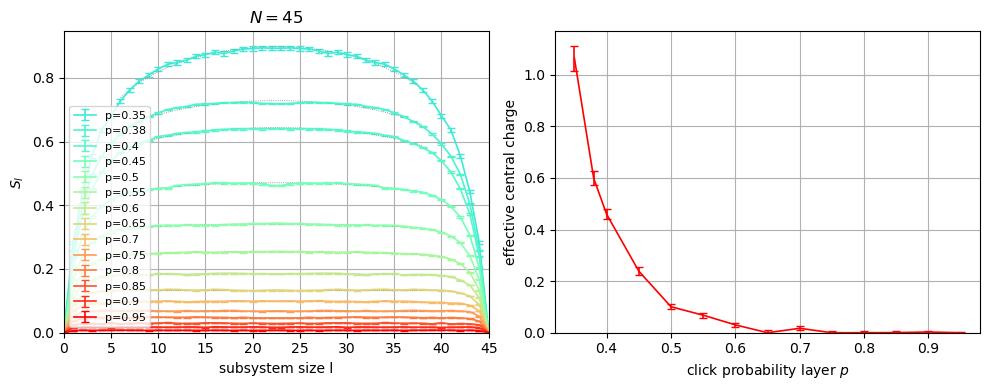

In [92]:
N_plot = 45

# function for critical fit
def log_scale(x,c,s0):
    return c/6*np.log(2*N_plot/np.pi*np.sin(np.pi*x/N_plot)) + s0

offset = 6

# PLOTS: 2 panels: (1) subsystem entanglement profiles, (2) effective critical charge
fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.style.use('default')

# FIRST PANEL
x_axis = np.linspace(0,N_plot,N_plot+1)
x_offset = x_axis[offset:-offset-1] # for fit, exclude boundaries

# find index in v_N array
i_N = np.argmin(np.abs(v_N-N_plot))

# for storing parameters
c_list = []
s0_list = []
c_err_list = []
s0_err_list = []

for i_p, p in list(enumerate(v_p)):
    dat = mean_S[i_N][i_p,:]
    err = err_S[i_N][i_p,:]
    
    
    
    _ = ax[0].errorbar(x_axis,0.5*(dat+np.flip(dat)), yerr = err/np.sqrt(2), capsize=3, linewidth = 1.2, 
                     color=cmap(p/np.max(v_p)), label="p="+str(p))
    
    # perform fit and plot
    par,conv = curve_fit(log_scale, x_offset, dat[offset:-offset-1], bounds=(0, [20,20]))
    Sfit = log_scale(x_offset, par[0], par[1])
    _ = ax[0].plot(x_offset, Sfit, color="grey", linestyle=":", linewidth=0.6)
    
    # save shit
    c_list.append(par[0])
    s0_list.append(par[1])
    c_err_list.append(np.sqrt(conv[0][0]))
    s0_err_list.append(np.sqrt(conv[1][1]))

ax[0].set_xlim(0,N_plot)
ax[0].set_ylim(bottom=0.)
ax[0].grid(True)
ax[0].legend(loc="lower left", fontsize=8)
ax[0].set_title(r"$N=$" + str(N_plot))

ax[0].set_xlabel("subsystem size l")
ax[0].set_ylabel(r"$S_l$")

# SECOND PANEL
ax[1].errorbar(v_p,c_list,yerr=c_err_list,capsize=3, linewidth = 1.2, 
                     color=cmap(p/np.max(v_p)))

ax[1].set_ylim(bottom=0.)
ax[1].grid(True)
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel("effective central charge")

plt.tight_layout()
plt.savefig("subsystem_" + analysis_type + ".pdf")

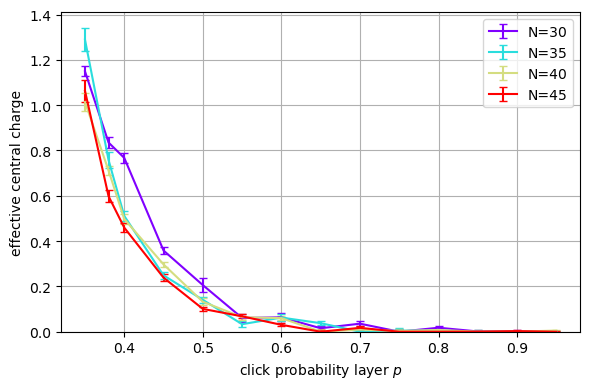

In [93]:
v_N_plot = [30,35,40,45]
offset = 6 # offset from boundary

c_data = []
s0_data = []
c_err_data = []
s0_err_data = []

for N in v_N_plot:
    
    i_N = np.argmin(np.abs(v_N-N))
    
    # function for critical fit
    def log_scale(x,c,s0):
        return c/6*np.log(2*N/np.pi*np.sin(np.pi*x/N)) + s0
    
    c_list_N = []
    s0_list_N = []
    c_err_list_N = []
    s0_err_list_N = []
    
    x_axis = np.linspace(0,N,N+1)
    x_offset = x_axis[offset:-offset-1] # for fit, exclude boundaries
    
    for i_p, p in list(enumerate(v_p)):
        dat = mean_S[i_N][i_p,:]
        err = err_S[i_N][i_p,:]
        
        # perform fit to data
        par,conv = curve_fit(log_scale, x_offset, dat[offset:-offset-1], bounds=(0, [20,20]))
        
        # save shit for this p fits for N
        c_list_N.append(par[0])
        s0_list_N.append(par[1])
        c_err_list_N.append(np.sqrt(conv[0][0]))
        s0_err_list_N.append(np.sqrt(conv[1][1]))
    
    # save for different N
    c_data.append(c_list_N)
    s0_data.append(s0_list_N)
    c_err_data.append(c_err_list_N)
    s0_err_data.append(s0_err_list_N)
    
# PLOT
plt.figure(figsize=(6,4))
cmap = matplotlib.cm.rainbow
for i_N, N in list(enumerate(v_N_plot)):
    plt.errorbar(v_p,c_data[i_N], yerr=c_err_data[i_N], capsize=3.,
                 color=cmap((N-np.min(v_N_plot))/(np.max(v_N_plot)-np.min(v_N_plot))), label="N="+str(N))
    
plt.ylim(bottom=0.)
plt.grid(True)
plt.legend()
plt.xlabel(xlabel)
plt.ylabel("effective central charge")

plt.tight_layout()
plt.savefig("central_charge_" + analysis_type + ".pdf")

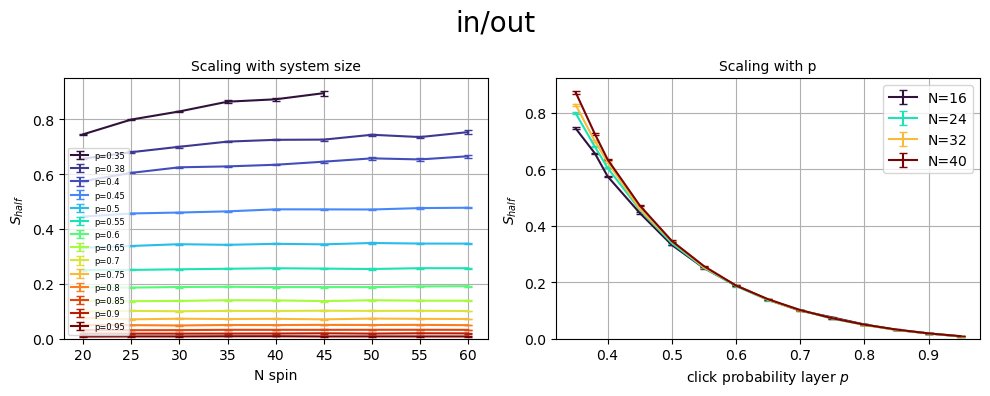

In [94]:

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.style.use('default')

# plotting colors
#p_plot = [.38,.4,.45,.5,.55,.6,.8]
#N_plot = [20,30,40,50,60]

p_plot = v_p
#p_plot = [0., .1, .4, .6, 1., 2.4, 3.2, 4., 5.]
N_plot = [16,24,32,40]

p_min = np.min(p_plot)
p_max = np.max(p_plot)
N_min = np.min(N_plot)
N_max = np.max(N_plot)

cmap = matplotlib.cm.turbo
# first panel:

x_axis = v_N

plt.suptitle("in/out", fontsize=20)


for p in p_plot:  
    i_p = np.argmin(np.abs(v_p-p))
    
    dat_plot = []
    dat_err = []
    
    for i_N in range(N_N):
        N = v_N[i_N]

        ind = np.unravel_index(np.argmax(mean_S[i_N][i_p], axis=None), mean_S[i_N][i_p].shape)
        dat_plot.append(mean_S[i_N][i_p][ind])
        dat_err.append(err_S[i_N][i_p][ind])

    _ = ax[0].errorbar(v_N,dat_plot, yerr=dat_err, capsize=3, 
                       color=cmap((p-p_min+1e-3)/(p_max-p_min+1e-3)), label="p="+str(p))


ax[0].set_ylim(bottom=0.)
#plt.xlim(v_N[0],v_N[3])
ax[0].grid(True)

ax[0].set_xlabel("N spin")
ax[0].set_ylabel(r"$S_{half}$")
ax[0].legend(loc="lower left",fontsize=6)
ax[0].set_title("Scaling with system size",fontsize=10)

# second panel

#x_axis = np.append(v_p,1.)
x_axis = v_p

for N in N_plot:
    i_N = np.argmin(np.abs(v_N-N))
    
    dat_plot = []
    dat_err = []
    
    for i_p in range(N_p):
        p = v_p[i_p]

        ind = np.unravel_index(np.argmax(mean_S[i_N][i_p], axis=None), mean_S[i_N][i_p].shape)
        dat_plot.append(mean_S[i_N][i_p][ind])
        dat_err.append(err_S[i_N][i_p][ind])

    #_ = ax[1].errorbar(x_axis,np.append(dat_plot,0.), yerr=np.append(dat_err,0.), capsize=3, 
                      #color=cmap((N-N_min)/(N_max-N_min)), label="N="+str(N))
    _ = ax[1].errorbar(x_axis,dat_plot, yerr=dat_err, capsize=3, 
                      color=cmap((N-N_min)/(N_max-N_min)), label="N="+str(N))


ax[1].set_ylim(bottom=0.)
#ax[1].set_xticks(x_axis)
#plt.xlim(v_N[0],v_N[3])
ax[1].grid(True)

ax[1].set_xlabel(xlabel)
ax[1].set_ylabel(r"$S_{half}$")
ax[1].legend()
ax[1].set_title("Scaling with p",fontsize=10)
fig.tight_layout()
plt.savefig("scaling_" + analysis_type + ".pdf")

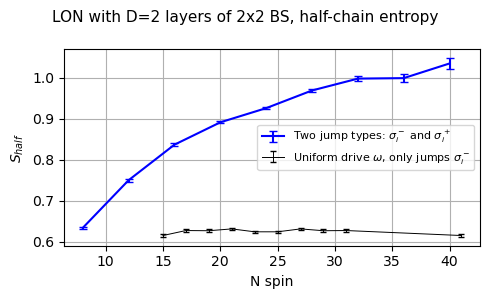

In [48]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
plt.style.use('default')

# plotting colors
#p_plot = [.38,.4,.45,.5,.55,.6,.8]
#N_plot = [20,30,40,50,60]

v_N_drive = np.array([15,17,19,21,23,25,27,29,31,41])
S_drive = np.array([0.6156736 , 0.6277609 , 0.62732663, 0.63176147, 0.62469643,
       0.62469643, 0.63176147, 0.62732663, 0.6277609 , 0.6156736 ])
err_drive = np.array([0.00299607, 0.00301953, 0.00307538, 0.00311651, 0.00306334,
       0.00304509, 0.00312283, 0.00309849, 0.00312724, 0.00309101])

p_plot = 0.
N_plot = v_N

p_min = np.min(p_plot)
p_max = np.max(p_plot)
N_min = np.min(N_plot)
N_max = np.max(N_plot)

cmap = matplotlib.cm.turbo
# first panel:

x_axis = v_N

plt.suptitle(r"LON with D=2 layers of 2x2 BS, half-chain entropy", fontsize=11)


 
i_p = np.argmin(np.abs(v_p-p_plot))

dat_plot = []
dat_err = []

for i_N in range(N_N):
    N = v_N[i_N]

    ind = np.unravel_index(np.argmax(mean_S[i_N][i_p], axis=None), mean_S[i_N][i_p].shape)
    dat_plot.append(mean_S[i_N][i_p][ind])
    dat_err.append(err_S[i_N][i_p][ind])

ax.errorbar(v_N,dat_plot, yerr=dat_err, capsize=3, 
                   color="blue", label=r"Two jump types: $\sigma^-_i$ and $\sigma^+_i$")

_ = ax.errorbar(v_N_drive,S_drive, yerr=err_drive, color="black", capsize=2, linewidth=.7, 
            label=r"Uniform drive $\omega$, only jumps $\sigma^-_i$")



#plt.xlim(v_N[0],v_N[3])
ax.grid(True)

ax.set_xlabel("N spin")
ax.set_ylabel(r"$S_{half}$")
ax.legend(fontsize=8)

fig.tight_layout()
plt.savefig("comp_drive_io.pdf")